In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.lstm3 = nn.LSTM(hidden_size2, hidden_size3, batch_first=True)
        self.dropout3 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_size3, 50)
        self.dropout4 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        out, _ = self.lstm3(out)
        out = self.dropout3(out)
        out = out[:, -1, :]
        out = torch.relu(self.fc1(out))
        out = self.dropout4(out)
        out = self.sigmoid(self.fc2(out))
        return out

In [3]:
# /home/mani/Desktop/main_project/data/csv/pe_data.csv
pe_data = pd.read_csv('/home/mani/Desktop/main_project/data/csv/pe_data.csv')

X = pe_data.drop(['Name', 'Label'], axis=1)
y = pe_data['Label']

# split the data into train, test and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train = X_train.values
X_test = X_test.values
X_val = X_val.values
y_train = y_train.values.flatten()
y_test = y_test.values.flatten()
y_val = y_val.values.flatten()

# Normalize the data using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# pca = PCA(n_components=7)

# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)
# X_val = pca.transform(X_val)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

In [4]:
input_size = X_train.shape[1]  # Update to the correct input size
hidden_size1 = 100
hidden_size2 = 50
hidden_size3 = 25
output_size = 1

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

model = LSTMModel(input_size, hidden_size1, hidden_size2,
                  hidden_size3, output_size)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/10, Loss: 0.2911, Accuracy: 0.9238, Validation Loss: 0.2748, Validation Accuracy: 0.9180
Epoch 2/10, Loss: 0.2469, Accuracy: 0.9326, Validation Loss: 0.2779, Validation Accuracy: 0.9160
Epoch 3/10, Loss: 0.2422, Accuracy: 0.9331, Validation Loss: 0.2776, Validation Accuracy: 0.9160
Epoch 4/10, Loss: 0.2400, Accuracy: 0.9332, Validation Loss: 0.2668, Validation Accuracy: 0.9160
Epoch 5/10, Loss: 0.2312, Accuracy: 0.9342, Validation Loss: 0.2561, Validation Accuracy: 0.9211
Epoch 6/10, Loss: 0.2228, Accuracy: 0.9354, Validation Loss: 0.2527, Validation Accuracy: 0.9200
Epoch 7/10, Loss: 0.2175, Accuracy: 0.9340, Validation Loss: 0.2487, Validation Accuracy: 0.9221
Epoch 8/10, Loss: 0.2158, Accuracy: 0.9361, Validation Loss: 0.2461, Validation Accuracy: 0.9231
Epoch 9/10, Loss: 0.2159, Accuracy: 0.9376, Validation Loss: 0.2408, Validation Accuracy: 0.9251
Epoch 10/10, Loss: 0.2112, Accuracy: 0.9381, Validation Loss: 0.2381, Validation Accuracy: 0.9261


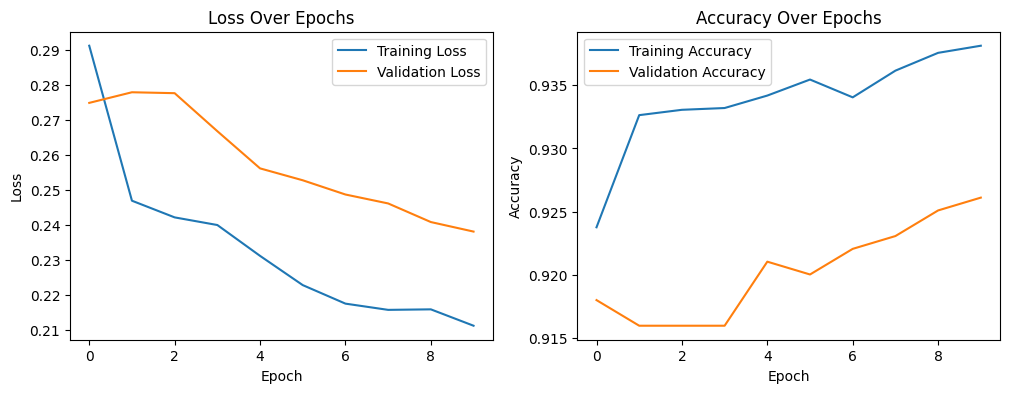

In [5]:


num_epochs = 10
batch_size = 32

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0

    for i in range(0, len(X_train_tensor), batch_size):
        inputs = X_train_tensor[i:i+batch_size]
        labels = y_train_tensor[i:i+batch_size]

        optimizer.zero_grad()
        # Add a third dimension for the input feature
        outputs = model(inputs.unsqueeze(2))
        loss = criterion(outputs, labels.unsqueeze(1)
                         )  # Adjust labels dimension
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct_train += torch.sum((outputs > 0.5).float()
                                   == labels.unsqueeze(1))

    average_loss = running_loss / (len(X_train_tensor) / batch_size)
    accuracy = correct_train.item() / len(X_train_tensor)

    # Validation
    model.eval()
    val_outputs = model(X_test_tensor.unsqueeze(2))
    val_loss = criterion(val_outputs, y_test_tensor.unsqueeze(1))
    correct_val = torch.sum((val_outputs > 0.5).float()
                            == y_test_tensor.unsqueeze(1))
    val_accuracy = correct_val.item() / len(X_test_tensor)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}, Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Store metrics
    train_losses.append(average_loss)
    train_accuracies.append(accuracy)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy)

# accuracy on test set
model.eval()
test_outputs = model(X_test_tensor.unsqueeze(2))
test_loss = criterion(test_outputs, y_test_tensor.unsqueeze(1))
correct_test = torch.sum((test_outputs > 0.5).float() == y_test_tensor.unsqueeze(1))
test_accuracy = correct_test.item() / len(X_test_tensor)
print(f"Test Loss: {test_loss.item():.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plot the metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()